In [64]:
import numpy as np 
from tqdm import tqdm 
from environment import Enviroment
import matplotlib.pyplot as plt 

# Value Table

In [42]:
value_function = np.load("./theoretical/value_function.npy")

In [43]:
value_function

array([[ 5.61344469,  8.9999211 , 11.75661048, 13.83162614],
       [ 8.99481133, 12.38128889, 15.13797997, 17.21299667],
       [11.8889956 , 15.27547344, 18.03216484, 20.10718163],
       [14.03204792, 17.41852942, 20.17522531, 22.25024349]])

# Actions

In [44]:
actions = np.load("./theoretical/actions.npy") 

# Policy visualization

In [45]:
policy_history = np.load("./theoretical/history.npy")

In [46]:
for policy in policy_history: 
    print(policy) 

[[[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]]
[[[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]]


In [47]:
optimal_policy = policy_history[-1]

In [48]:
print(optimal_policy) 

[[[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]

 [[0 0]
  [0 0]
  [0 0]
  [0 0]]]


# Examine the efficiency of each policy 

In [49]:
class Tester: 
    def __init__(self, cars1, cars2, cars_max, policy, actions): 
        self.cars1 = cars1
        self.cars2 = cars2 
        self.cars_max = cars_max
        self.policy = policy
        self.actions = actions

    def update_cars(self, new_car_1, new_car_2): 
        self.cars1 = new_car_1
        self.cars2 = new_car_2

    def get_cars(self): 
        return (self.cars1, self.cars2)

    def get_action_index(self, s): 
        action_index = self.policy[s]
        action_index = tuple(action_index)
        return action_index

    def get_action(self, action_index): 
        return self.actions[action_index] 

In [50]:
constants = np.load("./theoretical/constants.npy")
number_of_days = 2000000

In [51]:
rewards = np.load("./theoretical/rewards.npy")
rewards

array([10, -2])

In [52]:
actions

array([[ 0,  1,  2,  3],
       [ 0, -1, -2, -3]])

In [53]:
max_number_of_cars, expected_request_lambda_1, expected_request_lambda_2, expected_return_lambda_1, expected_return_lambda_2 = constants

In [54]:
environment = Enviroment(expected_request_lambda_1=expected_request_lambda_1, expected_request_lambda_2=expected_request_lambda_2,
                             expected_return_lambda_1=expected_return_lambda_1, expected_return_lambda_2=expected_return_lambda_2, agent=None)

In [55]:
cars1 = 2
cars2 = 1

tester_list = [] 
np.random.seed(42) 

for policy in policy_history: 
    tester = Tester(cars1, cars2, max_number_of_cars, policy=policy, actions=actions)

    tester_list.append(tester) 

In [56]:
reward_list = []
for i, tester in enumerate(tester_list): 
    current_reward = 0.0

    for d in tqdm(range(number_of_days), desc=f"Simulating sales for tester {i}"): 
        rental_request_1, rental_request_2 = environment.get_rental_requests()
        customer_return_1, customer_return_2 = environment.get_customer_returns()

        # current number of cars 
        cars1, cars2 = tester.get_cars()

        # renting out the cars
        cars_rented_1 = min(cars1, rental_request_1)
        cars_rented_2 = min(cars2, rental_request_2)

        # calculate reward for cars rented
        current_reward += rewards[0] * cars_rented_1
        current_reward += rewards[0] * cars_rented_2

        # calculate new car number for tomorrow
        cars1 -= cars_rented_1
        cars2 -= cars_rented_2

        cars1 += customer_return_1
        cars2 += customer_return_2

        # set cars to not exceed limit
        cars1 = min(cars1, tester.cars_max)
        cars2 = min(cars2, tester.cars_max)

        # select the best action based on the current policy and current state
        action_index = tester.get_action_index((cars1, cars2))
        number_of_cars_moved = tester.get_action(action_index) 

        # cost of moving cars
        cost = rewards[1] * np.abs(number_of_cars_moved)
        current_reward += cost

        # update the cars to the number of cars moved
        cars1 += number_of_cars_moved
        cars2 -= number_of_cars_moved

        # set cars to not exceed the limit 
        cars1 = min(cars1, tester.cars_max)
        cars2 = min(cars2, tester.cars_max)

        # update new car numbers
        tester.update_cars(cars1, cars2)
    
    reward_list.append(current_reward)

reward_list = np.array(reward_list) 
best_policy = np.argmax(reward_list) 
print(f"best policy from simulation: {best_policy} || best policy from agent: {len(policy_history) - 1}")

Simulating sales for tester 1: 100%|██████████| 2000000/2000000 [00:14<00:00, 134608.07it/s]

best policy from simulation: 0 || best policy from agent: 1


In [57]:
reward_list

array([74160580., 74143980.])

In [58]:
difference = reward_list[best_policy] - reward_list[-1]
print(f"Difference between best in simulation and optimal policy: {difference}")

Difference between best in simulation and optimal policy: 16600.0


# Visualize policies as a contour

exception contour
exception contour


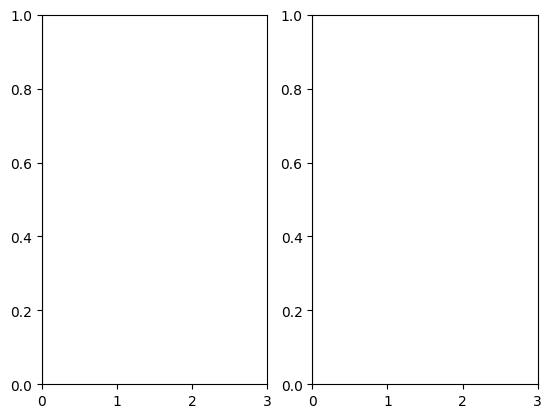

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2)

x = np.arange(0, max_number_of_cars + 1)
y = np.arange(0, max_number_of_cars + 1)

for policy_index, policy in enumerate(policy_history): 
    z = np.zeros_like(policy) 

    for i in range(policy.shape[0]): 
        for j in range(policy.shape[1]): 
            state = (i, j) 
            action_index = policy[state] 
            action = actions[action_index[0], action_index[1]]

            z[state] = action

    try: 
        axes[policy_index].contour([x, y], z)
    except Exception as e: 
        axes[policy_index].contour([x, y], z, levels=[0])
        print("exception contour")

plt.show()